In [1]:
# imports
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle

# graphing imports
import chart_studio
from chart_studio.plotly import plot, iplot
import plotly as py
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Exploration

In [2]:
# load in dataset
df = pd.read_csv('MLB-Stats.csv')
print(df.shape)
df.head()

(28293, 28)


playerID    Player Name  weight  height bats throws  Season League teamID  \
0  aardsda01  David Aardsma     215      75    R      R    2004     NL    SFN   
1  aardsda01  David Aardsma     215      75    R      R    2007     AL    CHA   
2  aardsda01  David Aardsma     215      75    R      R    2008     AL    BOS   
3  aardsda01  David Aardsma     215      75    R      R    2009     AL    SEA   
4  aardsda01  David Aardsma     215      75    R      R    2012     AL    NYA   

                   Team  ... RBI  SB  BB  SO  salary  IBB  HBP  SH  SF  PA  
0  San Francisco Giants  ...   0   0   0   0  300000    0    0   0   0   0  
1     Chicago White Sox  ...   0   0   0   0  387500    0    0   0   0   0  
2        Boston Red Sox  ...   0   0   0   1  403250    0    0   0   0   1  
3      Seattle Mariners  ...   0   0   0   0  419000    0    0   0   0   0  
4      New York Yankees  ...   0   0   0   0  500000    0    0   0   0   0  

[5 rows x 28 columns]

In [3]:
df = df.copy()

In [4]:
# df = df[df['Season'] == 1985]
# df.head()

In [5]:
# check for any missing data
df.isnull().sum()

playerID       0
Player Name    0
weight         0
height         0
bats           0
throws         0
Season         0
League         0
teamID         0
Team           0
Franchise      0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
BB             0
SO             0
salary         0
IBB            0
HBP            0
SH             0
SF             0
PA             0
dtype: int64

In [6]:
# interesting stat ideas
# avg salary by year - shows growth in cap, inflation
# total salary per team by year
# how has this changed since moneyball, statistics used to determine best value players?

In [7]:
# change column names from abbreviations to full names to help with domain knowledge
df = df.rename(columns={'G': 'Games_Played', 'AB': 'At_bats', 'R': 'Runs', 'H': 'Hits',
                   '2B': 'Doubles', '3B': 'Triples', 'HR': 'Home_Runs', 'SB': 'Stolen_Base',
                   'BB': 'Walk', 'SO': 'Strikeouts', 'IBB': 'Intentional_Walk', 'HBP': 'Hit_By_Pitch',
                   'SH': 'Sacrifice_Bunt', 'SF': 'Sacrifice_Fly', 'PA': 'Plate_Appearance'})
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance'],
      dtype='object')

In [8]:
# data exploration
df.describe().T

count          mean           std      min       25%  \
weight            28293.0  1.990493e+02  2.265398e+01    140.0     185.0   
height            28293.0  7.350019e+01  2.286595e+00     66.0      72.0   
Season            28293.0  2.000938e+03  8.900551e+00   1985.0    1994.0   
Games_Played      28293.0  6.393387e+01  4.728526e+01      1.0      26.0   
At_bats           28293.0  1.618799e+02  1.994066e+02      0.0       1.0   
Runs              28293.0  2.178684e+01  3.013390e+01      0.0       0.0   
Hits              28293.0  4.262454e+01  5.620091e+01      0.0       0.0   
Doubles           28293.0  8.220655e+00  1.140145e+01      0.0       0.0   
Triples           28293.0  9.091648e-01  1.832408e+00      0.0       0.0   
Home_Runs         28293.0  4.776977e+00  8.384449e+00      0.0       0.0   
RBI               28293.0  2.078376e+01  2.970482e+01      0.0       0.0   
Stolen_Base       28293.0  3.107518e+00  7.494805e+00      0.0       0.0   
Walk              28293.0  1.580172e+01  2.303636e+01      0.0       0.0   
Strikeouts        28293.0  3.037624e+01  3.762416e+01      0.0       0.0   
salary            28293.0  2.112965e+06  3.440239e+06  10900.0  300000.0   
Intentional_Walk  28293.0  1.326052e+00  3.160607e+00      0.0       0.0   
Hit_By_Pitch      28293.0  1.450642e+00  2.782354e+00      0.0       0.0   
Sacrifice_Bunt    28293.0  1.534549e+00  2.748349e+00      0.0       0.0   
Sacrifice_Fly     28293.0  1.366911e+00  2.207801e+00      0.0       0.0   
Plate_Appearance  28293.0  1.833598e+02  2.262174e+02      0.0       1.0   

                       50%        75%         max  
weight               195.0      215.0       315.0  
height                74.0       75.0        83.0  
Season              2001.0     2009.0      2016.0  
Games_Played          50.0      101.0       163.0  
At_bats               57.0      298.0       716.0  
Runs                   4.0       37.0       152.0  
Hits                  10.0       76.0       262.0  
Doubles                2.0       14.0        59.0  
Triples                0.0        1.0        23.0  
Home_Runs              0.0        6.0        73.0  
RBI                    4.0       34.0       165.0  
Stolen_Base            0.0        2.0       110.0  
Walk                   3.0       25.0       232.0  
Strikeouts            15.0       50.0       223.0  
salary            600000.0  2425000.0  33000000.0  
Intentional_Walk       0.0        1.0       120.0  
Hit_By_Pitch           0.0        2.0        35.0  
Sacrifice_Bunt         0.0        2.0        39.0  
Sacrifice_Fly          0.0        2.0        17.0  
Plate_Appearance      66.0      337.0       783.0

# Feature Engineering

In [9]:
# batting average - hits divided by total at-bats
df['Batting_Average'] = df['Hits'] / df['At_bats']

In [10]:
# how frequently a batter reaches base per plate appearance
# times on base include hits, walks and hit-by-pitches
df['On_Base_Percentage'] = (df['Hits'] + df['Walk'] + df['Hit_By_Pitch']) / df['Plate_Appearance']

In [11]:
# slugging percentage = (1B + 2Bx2 + 3Bx3 + HRx4)/AB
df['Slugging_Percentage'] = ((df['Hits'] - df['Doubles'] - df['Triples'] - df['Home_Runs']) +
                             (df['Doubles'] * 2) + (df['Triples'] * 3) + (df['Home_Runs'] * 4)) / df['At_bats']

In [12]:
# on-base plus slugging = on-base percentage + slugging percentage
df['On_Base_Plus_Slugging'] = df['On_Base_Percentage'] + df['Slugging_Percentage']

In [13]:
# walks as a percentage of plate appearances
df['Walk_Percentage'] = df['Walk'] / df['Plate_Appearance']

In [14]:
# strikeouts as a percentage of at bats
df['Strikeout_Percentage'] = df['Strikeouts'] / df['At_bats']

In [15]:
# walk to strikeout ratio
df['Walks_To_Strikeouts'] = df['Walk'] / df['Strikeouts']
df['Walks_To_Strikeouts'] = df['Walks_To_Strikeouts'].replace([np.inf, -np.inf], 0)

In [16]:
# player value
# df['Player_Value'] = (df['On_Base_Plus_Slugging'] / df['salary']) * 1000000
df['Player_Value'] = df['salary'] / df['On_Base_Plus_Slugging']

In [17]:
# any null values after feature engineering?
df.isnull().sum()

playerID                    0
Player Name                 0
weight                      0
height                      0
bats                        0
throws                      0
Season                      0
League                      0
teamID                      0
Team                        0
Franchise                   0
Games_Played                0
At_bats                     0
Runs                        0
Hits                        0
Doubles                     0
Triples                     0
Home_Runs                   0
RBI                         0
Stolen_Base                 0
Walk                        0
Strikeouts                  0
salary                      0
Intentional_Walk            0
Hit_By_Pitch                0
Sacrifice_Bunt              0
Sacrifice_Fly               0
Plate_Appearance            0
Batting_Average          6477
On_Base_Percentage       6343
Slugging_Percentage      6477
On_Base_Plus_Slugging    6477
Walk_Percentage          6343
Strikeout_

In [18]:
# a look before dropping null values
print(df.shape)
df.head()

(28293, 36)


playerID    Player Name  weight  height bats throws  Season League teamID  \
0  aardsda01  David Aardsma     215      75    R      R    2004     NL    SFN   
1  aardsda01  David Aardsma     215      75    R      R    2007     AL    CHA   
2  aardsda01  David Aardsma     215      75    R      R    2008     AL    BOS   
3  aardsda01  David Aardsma     215      75    R      R    2009     AL    SEA   
4  aardsda01  David Aardsma     215      75    R      R    2012     AL    NYA   

                   Team  ... Sacrifice_Fly  Plate_Appearance  Batting_Average  \
0  San Francisco Giants  ...             0                 0              NaN   
1     Chicago White Sox  ...             0                 0              NaN   
2        Boston Red Sox  ...             0                 1              0.0   
3      Seattle Mariners  ...             0                 0              NaN   
4      New York Yankees  ...             0                 0              NaN   

   On_Base_Percentage  Slugging_Percentage  On_Base_Plus_Slugging  \
0                 NaN                  NaN                    NaN   
1                 NaN                  NaN                    NaN   
2                 0.0                  0.0                    0.0   
3                 NaN                  NaN                    NaN   
4                 NaN                  NaN                    NaN   

   Walk_Percentage  Strikeout_Percentage  Walks_To_Strikeouts  Player_Value  
0              NaN                   NaN                  NaN           NaN  
1              NaN                   NaN                  NaN           NaN  
2              0.0                   1.0                  0.0           inf  
3              NaN                   NaN                  NaN           NaN  
4              NaN                   NaN                  NaN           NaN  

[5 rows x 36 columns]

In [19]:
# drop null and infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print(df.shape)
df.head()

(18899, 36)


playerID    Player Name  weight  height bats throws  Season League  \
10   abadan01      Andy Abad     184      73    L      L    2006     NL   
12   abadfe01  Fernando Abad     220      73    L      L    2012     NL   
17  abbotje01    Jeff Abbott     190      74    R      L    1998     AL   
18  abbotje01    Jeff Abbott     190      74    R      L    1999     AL   
19  abbotje01    Jeff Abbott     190      74    R      L    2000     AL   

   teamID               Team  ... Sacrifice_Fly  Plate_Appearance  \
10    CIN    Cincinnati Reds  ...             0                 5   
12    HOU     Houston Astros  ...             0                 7   
17    CHA  Chicago White Sox  ...             5               261   
18    CHA  Chicago White Sox  ...             1                64   
19    CHA  Chicago White Sox  ...             1               242   

    Batting_Average  On_Base_Percentage  Slugging_Percentage  \
10         0.000000            0.400000             0.000000   
12         0.142857            0.142857             0.142857   
17         0.278689            0.295019             0.491803   
18         0.157895            0.218750             0.263158   
19         0.274419            0.338843             0.395349   

    On_Base_Plus_Slugging  Walk_Percentage  Strikeout_Percentage  \
10               0.400000         0.400000              0.000000   
12               0.285714         0.000000              0.428571   
17               0.786822         0.034483              0.114754   
18               0.481908         0.078125              0.210526   
19               0.734192         0.086777              0.176744   

    Walks_To_Strikeouts  Player_Value  
10             0.000000  8.175000e+05  
12             0.000000  1.697500e+06  
17             0.321429  2.224136e+05  
18             0.416667  5.291468e+05  
19             0.552632  3.473207e+05  

[5 rows x 36 columns]

In [20]:
# getting oldest season for a player
year = df[['playerID', 'Season']]
year = year.rename(columns={'Season': 'Oldest_Season'})
year = year.sort_values('playerID').groupby('playerID').min()
year.head(10)

Oldest_Season
playerID                
abadan01            2006
abadfe01            2012
abbotje01           1998
abbotji01           1999
abbotku01           1993
abbotky01           1992
abbotpa01           2000
abercre01           2006
abernbr01           2002
abnersh01           1988

In [21]:
# merging oldest season
df = df.merge(year, how='inner', on='playerID')
# determining years in the league
df['Years_In_League'] = df['Season'] - df['Oldest_Season']

In [22]:
print(df.shape)
df.head()

(18899, 38)


playerID    Player Name  weight  height bats throws  Season League teamID  \
0   abadan01      Andy Abad     184      73    L      L    2006     NL    CIN   
1   abadfe01  Fernando Abad     220      73    L      L    2012     NL    HOU   
2  abbotje01    Jeff Abbott     190      74    R      L    1998     AL    CHA   
3  abbotje01    Jeff Abbott     190      74    R      L    1999     AL    CHA   
4  abbotje01    Jeff Abbott     190      74    R      L    2000     AL    CHA   

                Team  ... Batting_Average  On_Base_Percentage  \
0    Cincinnati Reds  ...        0.000000            0.400000   
1     Houston Astros  ...        0.142857            0.142857   
2  Chicago White Sox  ...        0.278689            0.295019   
3  Chicago White Sox  ...        0.157895            0.218750   
4  Chicago White Sox  ...        0.274419            0.338843   

   Slugging_Percentage  On_Base_Plus_Slugging  Walk_Percentage  \
0             0.000000               0.400000         0.400000   
1             0.142857               0.285714         0.000000   
2             0.491803               0.786822         0.034483   
3             0.263158               0.481908         0.078125   
4             0.395349               0.734192         0.086777   

   Strikeout_Percentage  Walks_To_Strikeouts  Player_Value  Oldest_Season  \
0              0.000000             0.000000  8.175000e+05           2006   
1              0.428571             0.000000  1.697500e+06           2012   
2              0.114754             0.321429  2.224136e+05           1998   
3              0.210526             0.416667  5.291468e+05           1998   
4              0.176744             0.552632  3.473207e+05           1998   

   Years_In_League  
0                0  
1                0  
2                0  
3                1  
4                2  

[5 rows x 38 columns]

In [23]:
# how stats are changing from season to season?
# the average weight of players has increased from 187 in 1985 to 212 in 2016
# the average salary of players has increased from 479k in 1985 to 4.49m in 2016
df.groupby('Season').mean()

weight     height  Games_Played     At_bats       Runs       Hits  \
Season                                                                          
1985    185.088993  72.950820     93.091335  282.487119  36.480094  73.868852   
1986    185.994555  72.954628     85.139746  249.558984  32.675136  64.784029   
1987    185.623984  72.930894     84.520325  251.628049  35.044715  66.943089   
1988    185.737769  72.943249     84.684932  257.432485  31.491194  65.868885   
1989    186.034862  72.928440     83.289908  249.735780  30.660550  64.141284   
1990    186.115646  72.897959     77.102041  226.957483  28.571429  58.872449   
1991    186.737166  73.022587     84.806982  252.143737  32.250513  65.082136   
1992    186.596685  72.878453     81.889503  244.524862  30.023941  62.977901   
1993    188.041602  72.978428     76.827427  231.260401  31.248074  61.691834   
1994    187.354730  72.954392     59.368243  183.555743  26.307432  49.736486   
1995    187.785818  72.894356     66.881331  198.412446  28.131693  53.138929   
1996    189.172263  72.969343     75.499270  224.513869  32.830657  60.798540   
1997    189.381955  72.972932     76.201504  227.508271  31.757895  61.013534   
1998    192.163488  73.151226     75.245232  224.538147  31.370572  60.088556   
1999    192.129346  73.112656     76.411683  228.137691  33.876217  62.200278   
2000    191.953125  73.043750     78.085938  236.781250  35.800000  64.732812   
2001    194.711783  73.117834     78.968153  240.721338  33.977707  64.125796   
2002    196.400974  73.040584     81.048701  243.995130  33.326299  64.193182   
2003    198.023411  72.978261     81.322742  249.780936  34.702341  66.546823   
2004    199.851027  73.065068     82.111301  255.405822  36.208904  68.672945   
2005    200.989744  73.111111     82.135043  255.408547  34.524786  68.099145   
2006    203.648604  73.126437     78.614122  246.376026  35.095238  66.814450   
2007    205.255102  73.137755     81.569728  254.374150  35.442177  68.568027   
2008    207.732639  73.104167     81.833333  255.894097  35.032986  68.064236   
2009    209.605263  73.159649     81.868421  258.421053  35.394737  68.524561   
2010    211.000000  73.234375     79.539931  248.795139  32.498264  64.659722   
2011    212.066434  73.248252     80.431818  252.444056  32.026224  64.912587   
2012    212.029060  73.147009     79.135043  246.752137  31.695726  63.364103   
2013    211.809609  73.153025     80.437722  254.724199  31.562278  65.209964   
2014    212.234694  73.185374     78.858844  248.093537  29.867347  62.845238   
2015    211.403114  73.250865     78.916955  246.669550  30.910035  63.174740   
2016    210.283186  73.385841     81.244248  255.302655  34.056637  65.881416   

          Doubles   Triples  Home_Runs        RBI  ...  Batting_Average  \
Season                                             ...                    
1985    13.021077  1.915691   7.475410  34.995316  ...         0.232419   
1986    11.459165  1.517241   6.816697  30.756806  ...         0.230404   
1987    11.969512  1.532520   8.087398  33.422764  ...         0.233027   
1988    11.669276  1.518591   5.886497  29.818004  ...         0.225225   
1989    11.121101  1.544954   5.493578  28.732110  ...         0.230533   
1990    10.469388  1.386054   5.292517  27.020408  ...         0.228003   
1991    11.677618  1.624230   6.172485  30.854209  ...         0.226494   
1992    11.416206  1.443831   5.364641  28.281768  ...         0.228923   
1993    11.141757  1.400616   6.080123  29.514638  ...         0.237378   
1994     9.570946  1.175676   5.550676  24.947635  ...         0.246441   
1995    10.021708  1.186686   5.887120  26.542692  ...         0.239739   
1996    11.454015  1.220438   7.202920  31.108029  ...         0.237347   
1997    11.792481  1.296241   6.872180  30.210526  ...         0.238813   
1998    11.833787  1.201635   6.859673  29.885559  ...         0.233681   
1999    11.987483  1.287900   7.593880  32.187761  ...   

In [24]:
# TODO - get the sum of each teams salaries for each season
# this is only for hitters not for pitchers?
df.groupby(['Season', 'Team']).sum()

weight  height  Games_Played  At_bats  Runs  \
Season Team                                                                
1985   Atlanta Braves          3349    1314          1643     4526   513   
       Baltimore Orioles       2997    1169          1658     5163   782   
       Boston Red Sox          2565    1013          1497     5184   726   
       California Angels       2320     942          1506     4826   646   
       Chicago Cubs            4107    1623          1829     4817   603   
...                             ...     ...           ...      ...   ...   
2016   St. Louis Cardinals     4415    1538          1755     5037   699   
       Tampa Bay Rays          3960    1401          1450     4720   596   
       Texas Rangers           4255    1458          1419     4491   645   
       Toronto Blue Jays       3875    1388          1705     5386   746   
       Washington Nationals    4170    1405          1649     4983   682   

                             Hits  Doubles  Triples  Home_Runs  RBI  ...  \
Season Team                                                          ...   
1985   Atlanta Braves        1131      179       21        119  540  ...   
       Baltimore Orioles     1389      226       22        207  747  ...   
       Boston Red Sox        1478      270       28        151  712  ...   
       California Angels     1210      192       27        133  608  ...   
       Chicago Cubs          1252      213       23        141  588  ...   
...                           ...      ...      ...        ...  ...  ...   
2016   St. Louis Cardinals   1272      267       29        208  675  ...   
       Tampa Bay Rays        1167      250       30        197  570  ...   
       Texas Rangers         1189      227       17        184  630  ...   
       Toronto Blue Jays     1348      271       18        220  725  ...   
       Washington Nationals  1250      243       20        185  674  ...   

                             Batting_Average  On_Base_Percentage  \
Season Team                                                        
1985   Atlanta Braves               3.695250            4.565430   
       Baltimore Orioles            4.020885            5.177744   
       Boston Red Sox               3.781367            4.552983   
       California Angels            3.137721            4.119577   
       Chicago Cubs                 4.339344            5.686459   
...                                      ...                 ...   
2016   St. Louis Cardinals          4.774930            5.972454   
       Tampa Bay Rays               4.448819            5.610928   
       Texas Rangers                5.099080            6.005415   
       Toronto Blue Jays            4.174236            5.481401   
       Washington Nationals         4.298128            5.265149   

                             Slugging_Percentage  On_Base_Plus_Slugging  \
Season Team                                                               
1985   Atlanta Braves                   5.227826               9.793256   
       Baltimore Orioles                6.497565              11.675309   
       Boston Red Sox                   5.546651              10.099634   
       California Angels                4.887492               9.007069   
       Chicago Cubs                     6.224553              11.911012   
...                                          ...                    ...   
2016   St. Louis Cardinals              7.785444              13.757897   
       Tampa Bay Rays                   7.187315              12.798243   
       Texas Rangers                    9.250704              15.256119   
       Toronto Blue Jays                6.711430              12.192831   
       Washington Nationals             6.700147              11.965296   

                             Walk_Percentage  Strikeout_Percentage  \
Season Team                                                          
1985   Atlanta Braves               1.292609      

In [25]:
# average salary by year for all field players
avg_salary = pd.DataFrame(df['salary'].groupby(df['Season']).mean().astype(int))
avg_salary.columns = ['Avg_Salary']
avg_salary.tail()

Avg_Salary
Season            
2012       4127921
2013       4292323
2014       4517652
2015       5157664
2016       5293829

In [26]:
# standardizing salaries 
# avg_salary['Inflation_Adj'] = 4492526 / avg_salary['Avg_Salary']
# avg_salary

In [27]:
df = df.merge(avg_salary, how='inner', on='Season')
df.head()

playerID         Player Name  weight  height bats throws  Season League  \
0   abadan01           Andy Abad     184      73    L      L    2006     NL   
1  abercre01  Reggie Abercrombie     215      75    R      R    2006     NL   
2  abreubo01         Bobby Abreu     220      72    L      R    2006     AL   
3  abreubo01         Bobby Abreu     220      72    L      R    2006     NL   
4  adamsru01          Russ Adams     205      72    L      R    2006     AL   

  teamID                   Team  ... On_Base_Percentage  Slugging_Percentage  \
0    CIN        Cincinnati Reds  ...           0.400000             0.000000   
1    FLO        Florida Marlins  ...           0.265018             0.333333   
2    NYA       New York Yankees  ...           0.413655             0.507177   
3    PHI  Philadelphia Phillies  ...           0.422122             0.433628   
4    TOR      Toronto Blue Jays  ...           0.278571             0.318725   

   On_Base_Plus_Slugging  Walk_Percentage  Strikeout_Percentage  \
0               0.400000         0.400000              0.000000   
1               0.598351         0.063604              0.305882   
2               0.920832         0.132530              0.248804   
3               0.855750         0.205418              0.253687   
4               0.597297         0.078571              0.163347   

   Walks_To_Strikeouts  Player_Value  Oldest_Season  Years_In_League  \
0             0.000000  8.175000e+05           2006                0   
1             0.230769  5.465020e+05           2006                0   
2             0.634615  1.476926e+07           1997                9   
3             1.058140  1.589249e+07           1997                9   
4             0.536585  5.742541e+05           2005                1   

   Avg_Salary  
0     3257097  
1     3257097  
2     3257097  
3     3257097  
4     3257097  

[5 rows x 39 columns]

In [28]:
df.to_csv('MLB_data_export.csv')

In [28]:
oak_players = df[df['teamID'] == 'OAK']
oak_players = oak_players[oak_players['Season'] == 2002]
oak_players

playerID      Player Name  weight  height bats throws  Season League  \
8419  chaveer01      Eric Chavez     215      73    L      R    2002     AL   
8430  colanmi01   Mike Colangelo     185      73    R      R    2002     AL   
8473  durhara01       Ray Durham     170      68    B      R    2002     AL   
8474    dyeje01     Jermaine Dye     210      76    R      R    2002     AL   
8513  giambje01    Jeremy Giambi     185      72    L      L    2002     AL   
8558  hattesc01  Scott Hatteberg     192      73    L      R    2002     AL   
8570  hernara02  Ramon Hernandez     220      72    R      R    2002     AL   
8583  hudsoti01       Tim Hudson     175      73    R      R    2002     AL   
8609  justida01    David Justice     195      75    L      L    2002     AL   
8652   longte01    Terrence Long     190      73    L      L    2002     AL   
8664  mabryjo01       John Mabry     195      76    L      R    2002     AL   
8694  menecfr01  Frank Menechino     175      69    R      R    2002     AL   
8724  myersgr01       Greg Myers     200      73    L      R    2002     AL   
8763   penaca01      Carlos Pena     225      74    L      L    2002     AL   
8823  saenzol01     Olmedo Saenz     185      74    R      R    2002     AL   
8871  tejadmi01    Miguel Tejada     220      69    R      R    2002     AL   
8896  velarra01    Randy Velarde     185      72    R      R    2002     AL   

     teamID               Team  ... On_Base_Percentage  Slugging_Percentage  \
8419    OAK  Oakland Athletics  ...           0.340841             0.512821   
8430    OAK  Oakland Athletics  ...           0.230769             0.217391   
8473    OAK  Oakland Athletics  ...           0.345382             0.456621   
8474    OAK  Oakland Athletics  ...           0.332136             0.459016   
8513    OAK  Oakland Athletics  ...           0.390374             0.471338   
8558    OAK  Oakland Athletics  ...           0.372583             0.432927   
8570    OAK  Oakland Athletics  ...           0.310044             0.334988   
8583    OAK  Oakland Athletics  ...           0.333333             0.400000   
8609    OAK  Oakland Athletics  ...           0.373418             0.409548   
8652    OAK  Oakland Athletics  ...           0.295666             0.390119   
8664    OAK  Oakland Athletics  ...           0.320755             0.523316   
8694    OAK  Oakland Athletics  ...           0.311688             0.325758   
8724    OAK  Oakland Athletics  ...           0.335260             0.381944   
8763    OAK  Oakland Athletics  ...           0.304965             0.419355   
8823    OAK  Oakland Athletics  ...           0.351955             0.467949   
8871    OAK  Oakland Athletics  ...           0.352368             0.507553   
8896    OAK  Oakland Athletics  ...           0.320513             0.330827   

      On_Base_Plus_Slugging  Walk_Percentage  Strikeout_Percentage  \
8419               0.853661         0.097598              0.203419   
8430               0.448161         0.038462              0.086957   
8473               0.802003         0.096386              0.155251   
8474               0.791153         0.093357              0.221311   
8513               0.861712         0.144385              0.254777   
8558               0.805510         0.119508              0.113821   
8570               0.645031         0.093886              0.158809   
8583               0.733333         0.166667              0.200000   
8609               0.782965         0.147679              0.165829   
8652               0.685785         0.074303              0.163543   
8664               0.844071         0.066038              0.191710   
8694               0.637446         0.129870              0.242424   
8724               0.717205         0.150289              0.250000   
8763               0.724319         0.106383              0.306452   
8823               0.819904         0.072626              0.198718   
8871               0.859921         0.052

In [29]:
# look at Oakland specifically
oak = df[df['teamID'] == 'OAK']
oak = oak.groupby(oak['Season']).mean()#.iloc[12:]
print(oak.shape)
oak

(32, 30)


weight     height  Games_Played     At_bats       Runs  \
Season                                                               
1985    184.000000  73.250000    118.333333  392.916667  53.916667   
1986    191.277778  73.500000     84.833333  284.500000  38.666667   
1987    187.187500  72.562500    101.562500  331.250000  48.750000   
1988    192.500000  72.785714    119.214286  376.500000  52.785714   
1989    194.058824  73.058824     94.705882  306.529412  40.764706   
1990    193.217391  73.260870     75.956522  234.000000  31.695652   
1991    190.333333  73.266667    105.533333  330.466667  47.866667   
1992    192.812500  73.312500     94.312500  299.125000  41.500000   
1993    187.000000  72.150000     83.050000  279.300000  35.450000   
1994    186.470588  72.294118     66.352941  219.411765  31.705882   
1995    185.000000  72.277778     82.500000  267.000000  39.833333   
1996    188.750000  72.550000     82.600000  263.600000  40.500000   
1997    197.250000  72.950000     84.850000  261.100000  35.100000   
1998    191.631579  72.263158     88.210526  280.315789  41.263158   
1999    192.000000  71.750000     92.100000  275.050000  44.650000   
2000    195.294118  72.058824     93.352941  278.647059  47.294118   
2001    199.800000  72.900000     79.650000  266.950000  42.100000   
2002    195.411765  72.647059     88.470588  288.294118  40.470588   
2003    198.266667  72.600000    100.866667  334.600000  47.466667   
2004    200.352941  73.176471     96.647059  331.411765  45.823529   
2005    200.500000  72.437500     92.375000  322.812500  44.375000   
2006    199.357143  72.428571    105.928571  368.500000  52.142857   
2007    200.285714  72.619048     63.666667  216.428571  27.952381   
2008    211.111111  73.000000     82.555556  260.722222  31.833333   
2009    216.428571  73.000000     89.214286  304.928571  41.785714   
2010    205.000000  72.444444     77.666667  258.333333  31.777778   
2011    210.357143  72.642857     93.642857  314.571429  36.928571   
2012    206.315789  71.789474     72.105263  243.631579  30.842105   
2013    207.714286  72.809524     80.714286  251.095238  35.285714   
2014    211.600000  72.150000     84.100000  269.100000  35.450000   
2015    202.647059  72.117647     84.176471  261.117647  31.705882   
2016    206.153846  71.846154     95.384615  331.692308  40.615385   

              Hits    Doubles   Triples  Home_Runs        RBI  ...  \
Season                                                         ...   
1985    104.083333  16.250000  2.500000  11.833333  49.500000  ...   
1986     72.444444  11.000000  1.388889   8.666667  36.388889  ...   
1987     86.375000  15.750000  2.062500  12.312500  46.562500  ...   
1988     98.714286  16.928571  1.285714  10.928571  51.285714  ...   
1989     80.882353  12.470588  1.470588   7.294118  37.647059  ...   
1990     59.565217   9.086957  0.956522   7.130435  30.086957  ...   
1991     83.266667  15.600000  1.200000  10.400000  45.733333  ...   
1992     77.187500  12.437500  1.187500   8.250000  39.187500  ...   
1993     71.500000  13.050000  1.100000   7.850000  34.600000  ...   
1994     57.882353  10.235294  0.823529   6.588235  29.882353  ...   
1995     70.444444  12.388889  0.944444   9.222222  37.500000  ...   
1996     69.850000  13.300000  1.000000  11.750000  39.250000  ...   
1997     67.650000  12.850000  0.950000   9.450000  33.700000  ...   
1998     72.684211  14.947368  0.631579   7.789474  38.842105  ...   
1999     71.400000  14.350000  1.000000  11.750000  42.200000  ...   
2000     74.882353  14.235294  0.823529  12.647059  47.176471  ...   
2001     71.550000  16.400000  1.000000   9.650000  40.700000  ...   
2002     75.705882  14.705882  1.235294  11.176471  41.294118  ...   
2003     85.266667  19.266667  1.533333  10.466667  45.000000  ...   
2004     89.882353  19.470588  0.882353  11.000000  43.588235  ...   
2005     84.812500  17.750000  1.250000   8.750000  42.062500  ...   
2006     95.857143  1

In [30]:
# look at rest of the league without Oakland in data
rest_of_league = df[df['teamID'] != 'OAK']
rest_of_league = df.groupby('Season').mean()# .iloc[12:]
print(rest_of_league.shape)
rest_of_league

(32, 30)


weight     height  Games_Played     At_bats       Runs       Hits  \
Season                                                                          
1985    185.088993  72.950820     93.091335  282.487119  36.480094  73.868852   
1986    185.994555  72.954628     85.139746  249.558984  32.675136  64.784029   
1987    185.623984  72.930894     84.520325  251.628049  35.044715  66.943089   
1988    185.737769  72.943249     84.684932  257.432485  31.491194  65.868885   
1989    186.034862  72.928440     83.289908  249.735780  30.660550  64.141284   
1990    186.115646  72.897959     77.102041  226.957483  28.571429  58.872449   
1991    186.737166  73.022587     84.806982  252.143737  32.250513  65.082136   
1992    186.596685  72.878453     81.889503  244.524862  30.023941  62.977901   
1993    188.041602  72.978428     76.827427  231.260401  31.248074  61.691834   
1994    187.354730  72.954392     59.368243  183.555743  26.307432  49.736486   
1995    187.785818  72.894356     66.881331  198.412446  28.131693  53.138929   
1996    189.172263  72.969343     75.499270  224.513869  32.830657  60.798540   
1997    189.381955  72.972932     76.201504  227.508271  31.757895  61.013534   
1998    192.163488  73.151226     75.245232  224.538147  31.370572  60.088556   
1999    192.129346  73.112656     76.411683  228.137691  33.876217  62.200278   
2000    191.953125  73.043750     78.085938  236.781250  35.800000  64.732812   
2001    194.711783  73.117834     78.968153  240.721338  33.977707  64.125796   
2002    196.400974  73.040584     81.048701  243.995130  33.326299  64.193182   
2003    198.023411  72.978261     81.322742  249.780936  34.702341  66.546823   
2004    199.851027  73.065068     82.111301  255.405822  36.208904  68.672945   
2005    200.989744  73.111111     82.135043  255.408547  34.524786  68.099145   
2006    203.648604  73.126437     78.614122  246.376026  35.095238  66.814450   
2007    205.255102  73.137755     81.569728  254.374150  35.442177  68.568027   
2008    207.732639  73.104167     81.833333  255.894097  35.032986  68.064236   
2009    209.605263  73.159649     81.868421  258.421053  35.394737  68.524561   
2010    211.000000  73.234375     79.539931  248.795139  32.498264  64.659722   
2011    212.066434  73.248252     80.431818  252.444056  32.026224  64.912587   
2012    212.029060  73.147009     79.135043  246.752137  31.695726  63.364103   
2013    211.809609  73.153025     80.437722  254.724199  31.562278  65.209964   
2014    212.234694  73.185374     78.858844  248.093537  29.867347  62.845238   
2015    211.403114  73.250865     78.916955  246.669550  30.910035  63.174740   
2016    210.283186  73.385841     81.244248  255.302655  34.056637  65.881416   

          Doubles   Triples  Home_Runs        RBI  ...  On_Base_Percentage  \
Season                                             ...                       
1985    13.021077  1.915691   7.475410  34.995316  ...            0.287285   
1986    11.459165  1.517241   6.816697  30.756806  ...            0.290605   
1987    11.969512  1.532520   8.087398  33.422764  ...            0.288427   
1988    11.669276  1.518591   5.886497  29.818004  ...            0.280063   
1989    11.121101  1.544954   5.493578  28.732110  ...            0.284984   
1990    10.469388  1.386054   5.292517  27.020408  ...            0.282279   
1991    11.677618  1.624230   6.172485  30.854209  ...            0.287694   
1992    11.416206  1.443831   5.364641  28.281768  ...            0.284668   
1993    11.141757  1.400616   6.080123  29.514638  ...            0.289178   
1994     9.570946  1.175676   5.550676  24.947635  ...            0.299924   
1995    10.021708  1.186686   5.887120  26.542692  ...            0.296774   
1996    11.454015  1.220438   7.202920  31.108029  ...            0.299688   
1997    11.792481  1.296241   6.872180  30.210526  ...            0.296539   
1998    11.833787  1.201635   6.859673  29.885559  ...            0.292793   
1999    1

In [31]:
diff = oak - rest_of_league
diff['salary'] = diff['salary'].astype(int)
diff.style.format({
 'Batting_Average': '{:,.2%}'.format, 
 'On_Base_Percentage': '{:,.2%}'.format,
 'Slugging_Percentage': '{:,.2%}'.format,
 'On_Base_Plus_Slugging': '{:,.2%}'.format,
 'Walk_Percentage': '{:,.2%}'.format,
 'Strikeout_Percentage': '{:,.2%}'.format,
 'Walks_To_Strikeouts': '{:,.2%}'.format
})

In [32]:
percent_diff = (oak / rest_of_league) - 1
percent_diff.style.format({
 'Runs': '{:,.2%}'.format, 
 'Hits': '{:,.2%}'.format, 
 'Doubles': '{:,.2%}'.format, 
 'Triples': '{:,.2%}'.format, 
 'Home_Runs': '{:,.2%}'.format, 
 'RBI': '{:,.2%}'.format, 
 'Stolen_Base': '{:,.2%}'.format, 
 'Walk': '{:,.2%}'.format, 
 'Strikeouts': '{:,.2%}'.format, 
 'salary': '{:,.2%}'.format, 
 'Batting_Average': '{:,.2%}'.format, 
 'On_Base_Percentage': '{:,.2%}'.format,
 'Slugging_Percentage': '{:,.2%}'.format,
 'On_Base_Plus_Slugging': '{:,.2%}'.format,
 'Walk_Percentage': '{:,.2%}'.format,
 'Strikeout_Percentage': '{:,.2%}'.format,
 'Walks_To_Strikeouts': '{:,.2%}'.format
})

In [33]:
salary_comp = pd.concat([oak['salary'].astype(int), rest_of_league['salary'].astype(int)], axis=1)
salary_comp.columns = ['Avg_Oakland_Salary', 'Avg_League_Salary']
salary_comp.head()

Avg_Oakland_Salary  Avg_League_Salary
Season                                       
1985                522361             492916
1986                373854             441170
1987                424634             440672
1988                353392             482264
1989                622911             537836

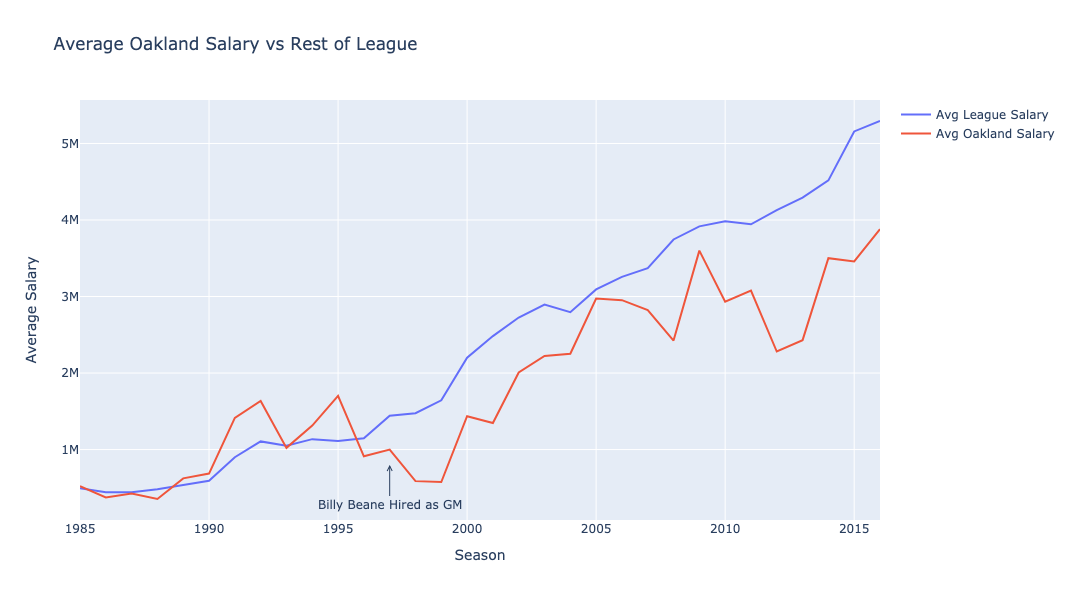

In [34]:
avg_league_salary = go.Scatter(x=salary_comp.index, y=salary_comp['Avg_League_Salary'],
                      name='Avg League Salary')

avg_oakland_salary = go.Scatter(x=salary_comp.index, y=salary_comp['Avg_Oakland_Salary'],
                      name='Avg Oakland Salary')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Salary vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Salary'))

fig = go.Figure(data=[avg_league_salary, avg_oakland_salary], layout=layout)

fig.add_annotation(
            x=1997,
            y=800000,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)


# iplot(fig, filename = 'Average Oakland Salary vs Rest of League', auto_open=True)

In [35]:
# TODO - df and graph for on base plus slugging for oakland vs the rest of the league
obp = pd.concat([oak['On_Base_Percentage'], rest_of_league['On_Base_Percentage']], axis=1)
obp.columns = ['Avg_Oakland_OBP', 'Avg_League_OBP']
obp.head()

Avg_Oakland_OBP  Avg_League_OBP
Season                                 
1985           0.322829        0.287285
1986           0.311147        0.290605
1987           0.322331        0.288427
1988           0.328375        0.280063
1989           0.315476        0.284984

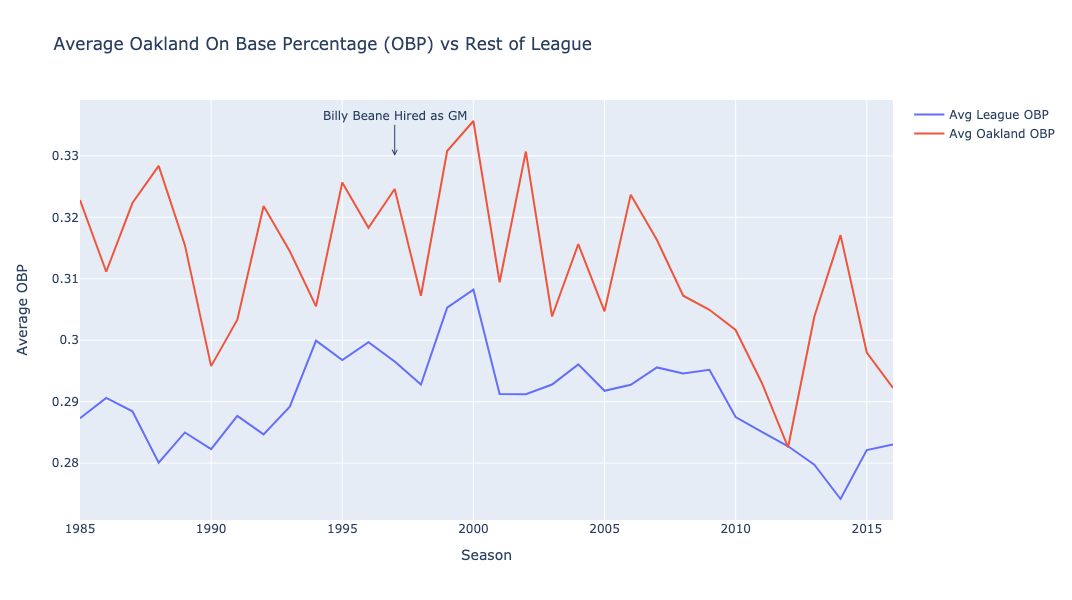

In [36]:
avg_league_obp = go.Scatter(x=obp.index, y=obp['Avg_League_OBP'],
                      name='Avg League OBP')

avg_oakland_obp = go.Scatter(x=obp.index, y=obp['Avg_Oakland_OBP'],
                      name='Avg Oakland OBP')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland On Base Percentage (OBP) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average OBP'))

fig = go.Figure(data=[avg_league_obp, avg_oakland_obp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.33,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
)

fig.show()

# iplot(fig, filename = 'Average Oakland OBP vs Rest of League', auto_open=True)

In [37]:
slg = pd.concat([oak['Slugging_Percentage'], rest_of_league['Slugging_Percentage']], axis=1)
slg.columns = ['Avg_Oakland_SLG', 'Avg_League_SLG']
slg.head()

Avg_Oakland_SLG  Avg_League_SLG
Season                                 
1985           0.407661        0.343963
1986           0.329521        0.344972
1987           0.403054        0.353512
1988           0.376966        0.325414
1989           0.374205        0.333632

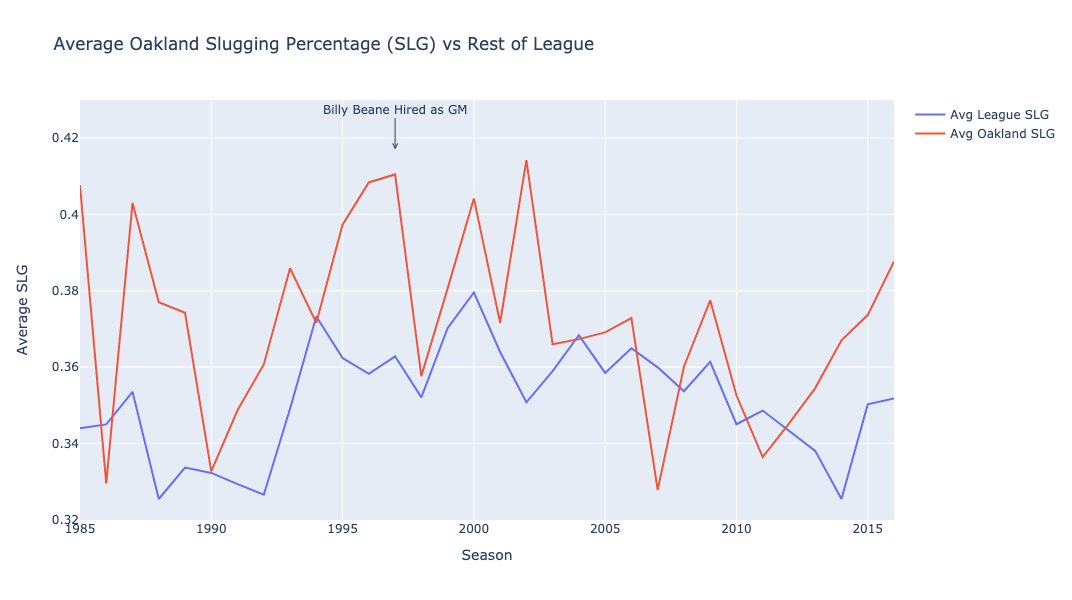

In [38]:
avg_league_slg = go.Scatter(x=slg.index, y=slg['Avg_League_SLG'],
                      name='Avg League SLG')

avg_oakland_slg = go.Scatter(x=slg.index, y=slg['Avg_Oakland_SLG'],
                      name='Avg Oakland SLG')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Slugging Percentage (SLG) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average SLG'))

fig = go.Figure(data=[avg_league_slg, avg_oakland_slg], layout=layout)

fig.add_annotation(
            x=1997,
            y=.417,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
)

fig.show()

In [39]:
# TODO - df and graph for on base plus slugging for oakland vs the rest of the league
on_base_plus_slug_comp = pd.concat([oak['On_Base_Plus_Slugging'], rest_of_league['On_Base_Plus_Slugging']], axis=1)
on_base_plus_slug_comp.columns = ['Avg_Oakland_OPS', 'Avg_League_OPS']
on_base_plus_slug_comp.head()

Avg_Oakland_OPS  Avg_League_OPS
Season                                 
1985           0.730490        0.631248
1986           0.640668        0.635577
1987           0.725385        0.641939
1988           0.705340        0.605478
1989           0.689681        0.618616

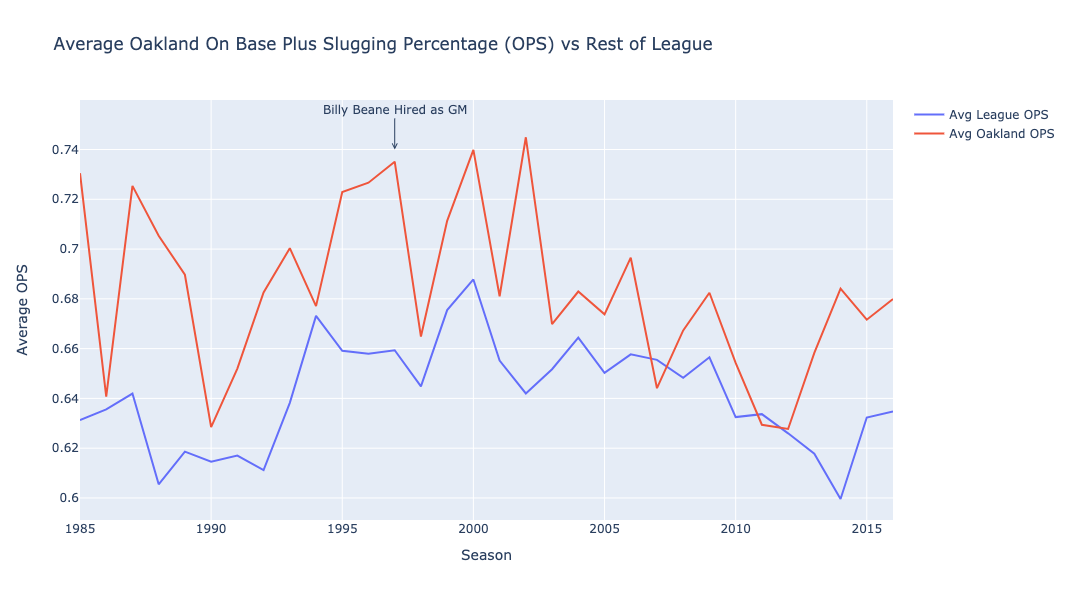

In [40]:
avg_league_ops = go.Scatter(x=on_base_plus_slug_comp.index, y=on_base_plus_slug_comp['Avg_League_OPS'],
                      name='Avg League OPS')

avg_oakland_ops = go.Scatter(x=on_base_plus_slug_comp.index, y=on_base_plus_slug_comp['Avg_Oakland_OPS'],
                      name='Avg Oakland OPS')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland On Base Plus Slugging Percentage (OPS) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average OPS'))

fig = go.Figure(data=[avg_league_ops, avg_oakland_ops], layout=layout)

fig.add_annotation(
            x=1997,
            y=.74,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
)

fig.show()

In [41]:
walk_percentage_comp = pd.concat([oak['Walk_Percentage'], rest_of_league['Walk_Percentage']], axis=1)
walk_percentage_comp.columns = ['Avg_Oakland_WP', 'Avg_League_WP']
walk_percentage_comp.head()

Avg_Oakland_WP  Avg_League_WP
Season                               
1985          0.078249       0.078727
1986          0.114227       0.081600
1987          0.098517       0.078068
1988          0.097671       0.075005
1989          0.091202       0.076022

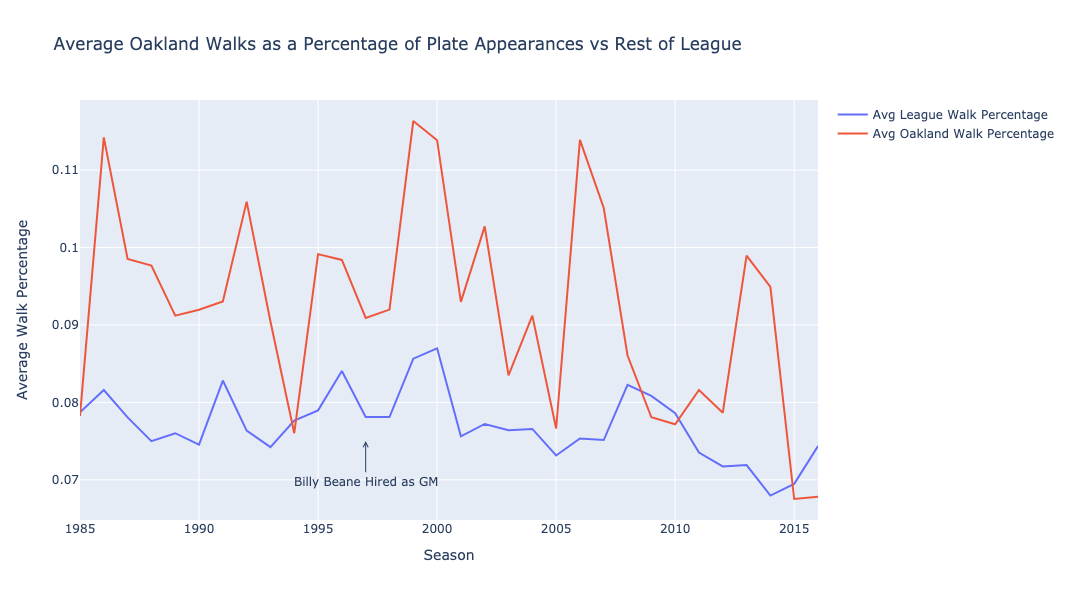

In [42]:
avg_league_wp = go.Scatter(x=walk_percentage_comp.index, y=walk_percentage_comp['Avg_League_WP'],
                      name='Avg League Walk Percentage')

avg_oakland_wp = go.Scatter(x=walk_percentage_comp.index, y=walk_percentage_comp['Avg_Oakland_WP'],
                      name='Avg Oakland Walk Percentage')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Walks as a Percentage of Plate Appearances vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Walk Percentage'))

fig = go.Figure(data=[avg_league_wp, avg_oakland_wp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.075,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

# iplot(fig, filename = 'Average Oakland OBP vs Rest of League', auto_open=True)

In [43]:
strikeout_percentage_comp = pd.concat([oak['Strikeout_Percentage'], rest_of_league['Strikeout_Percentage']], axis=1)
strikeout_percentage_comp.columns = ['Avg_Oakland_SP', 'Avg_League_SP']
strikeout_percentage_comp.head()

Avg_Oakland_SP  Avg_League_SP
Season                               
1985          0.152288       0.196921
1986          0.174635       0.218655
1987          0.206076       0.215904
1988          0.174308       0.205754
1989          0.166782       0.207104

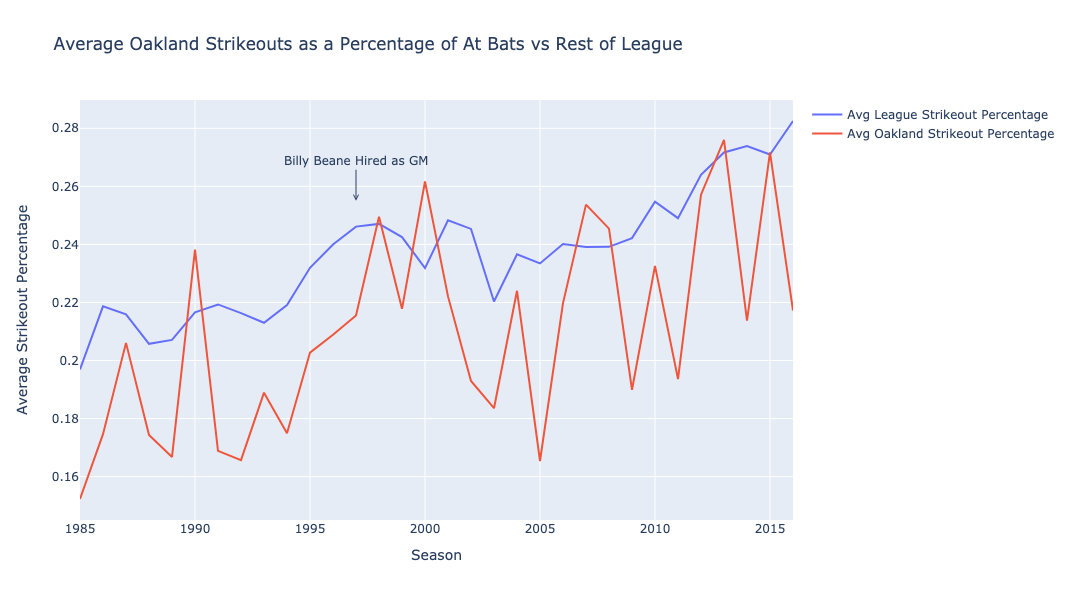

In [44]:
avg_league_sp = go.Scatter(x=strikeout_percentage_comp.index, y=strikeout_percentage_comp['Avg_League_SP'],
                      name='Avg League Strikeout Percentage')

avg_oakland_sp = go.Scatter(x=strikeout_percentage_comp.index, y=strikeout_percentage_comp['Avg_Oakland_SP'],
                      name='Avg Oakland Strikeout Percentage')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Strikeouts as a Percentage of At Bats vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Strikeout Percentage'))

fig = go.Figure(data=[avg_league_sp, avg_oakland_sp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.255,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
)

fig.show()

# iplot(fig, filename = 'Average Oakland Strikeouts vs Rest of League', auto_open=True)

In [45]:
walks_to_strikeouts = pd.concat([oak['Walks_To_Strikeouts'], rest_of_league['Walks_To_Strikeouts']], axis=1)
walks_to_strikeouts.columns = ['Avg_Oakland_WTS', 'Avg_League_WTS']
walks_to_strikeouts.head()

Avg_Oakland_WTS  Avg_League_WTS
Season                                 
1985           0.597596        0.648597
1986           0.494879        0.564530
1987           0.608505        0.557716
1988           0.665753        0.557151
1989           0.626295        0.570204

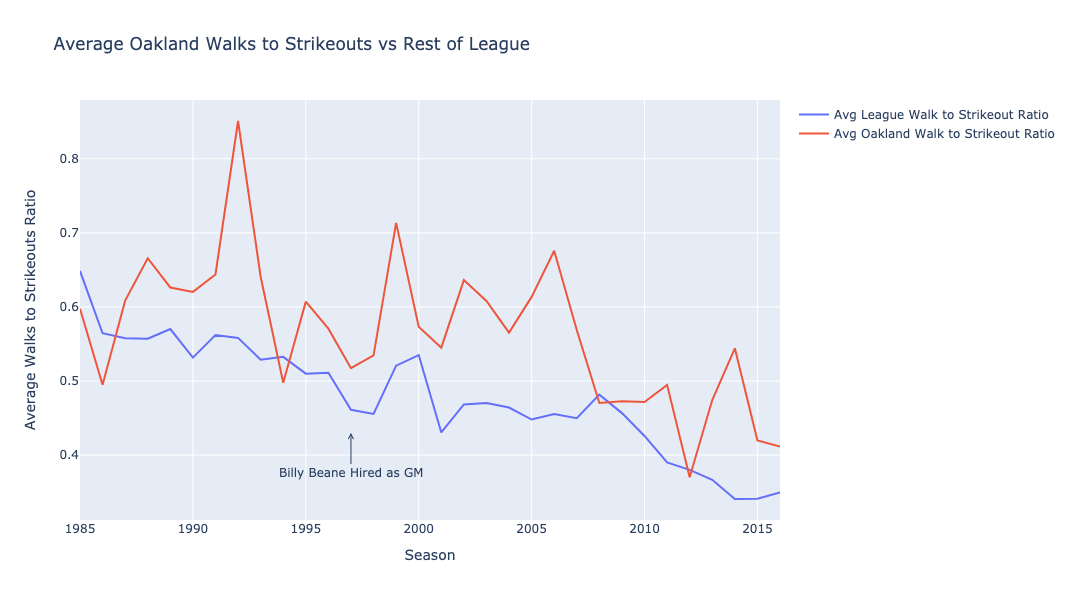

In [46]:
avg_league_wts = go.Scatter(x=walks_to_strikeouts.index, y=walks_to_strikeouts['Avg_League_WTS'],
                      name='Avg League Walk to Strikeout Ratio')

avg_oakland_wts = go.Scatter(x=walks_to_strikeouts.index, y=walks_to_strikeouts['Avg_Oakland_WTS'],
                      name='Avg Oakland Walk to Strikeout Ratio')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Walks to Strikeouts vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Walks to Strikeouts Ratio'))

fig = go.Figure(data=[avg_league_wts, avg_oakland_wts], layout=layout)

fig.add_annotation(
            x=1997,
            y=.43,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [47]:
player_value_comp = pd.concat([oak['Player_Value'], rest_of_league['Player_Value']], axis=1)
player_value_comp.columns = ['Avg_Oakland_PV', 'Avg_League_PV']
player_value_comp.head()

Avg_Oakland_PV  Avg_League_PV
Season                               
1985     725809.542807  941889.225440
1986     612914.294818  786550.733299
1987     574718.297095  794039.456900
1988     501368.063139  929773.298201
1989     833158.263995  987743.121626

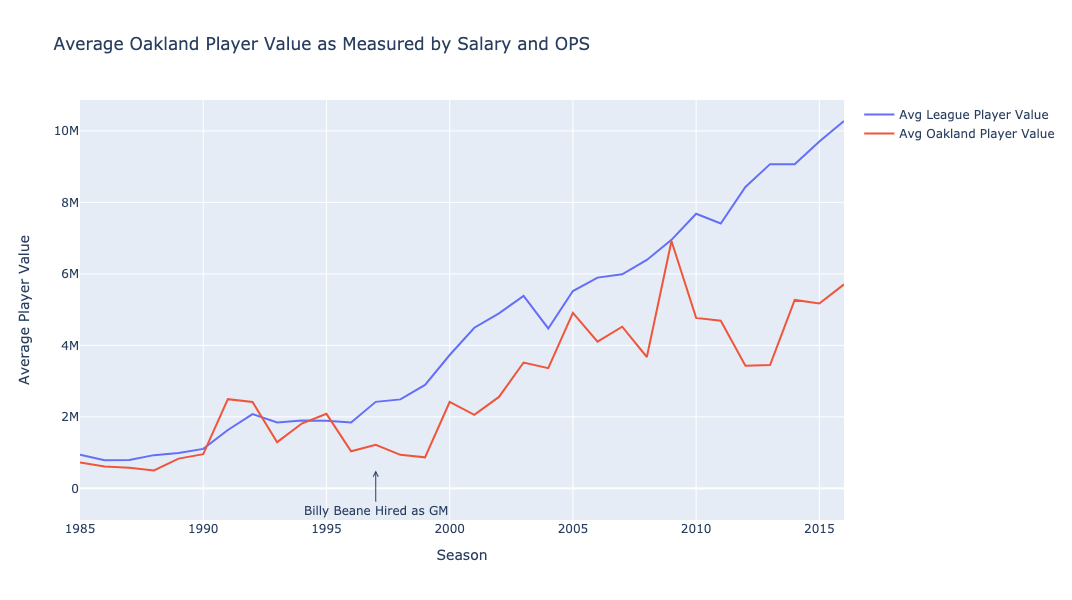

In [48]:
avg_league_pv = go.Scatter(x=player_value_comp.index, y=player_value_comp['Avg_League_PV'],
                      name='Avg League Player Value')

avg_oakland_pv = go.Scatter(x=player_value_comp.index, y=player_value_comp['Avg_Oakland_PV'],
                      name='Avg Oakland Player Value')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Player Value as Measured by Salary and OPS',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Player Value'))

fig = go.Figure(data=[avg_league_pv, avg_oakland_pv], layout=layout)

fig.add_annotation(
            x=1997,
            y=500000,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

# iplot(fig, filename = 'Average Oakland Player Value vs Rest of League', auto_open=True)

In [49]:
years_comp = pd.concat([oak['Years_In_League'], rest_of_league['Years_In_League']], axis=1)
years_comp.columns = ['Avg_Oakland_YC', 'Avg_League_YC']
years_comp = years_comp[years_comp.index >= 1990]
years_comp.head()

Avg_Oakland_YC  Avg_League_YC
Season                               
1990          2.826087       2.869048
1991          4.933333       3.462012
1992          4.875000       3.710866
1993          3.500000       3.440678
1994          5.235294       3.851351

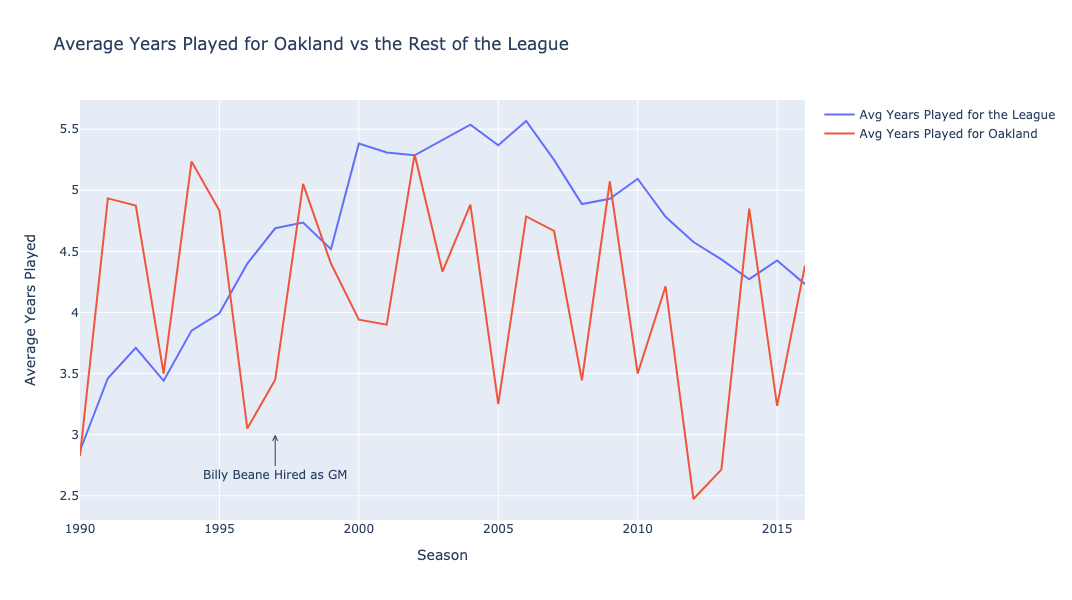

In [50]:
avg_league_yc = go.Scatter(x=years_comp.index, y=years_comp['Avg_League_YC'],
                      name='Avg Years Played for the League')

avg_oakland_yc = go.Scatter(x=years_comp.index, y=years_comp['Avg_Oakland_YC'],
                      name='Avg Years Played for Oakland')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Years Played for Oakland vs the Rest of the League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Years Played'))
                                                            
fig = go.Figure(data=[avg_league_yc, avg_oakland_yc], layout=layout)

fig.add_annotation(
            x=1997,
            y=3,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

# iplot(fig, filename = 'Average Oakland Years Played vs Rest of League', auto_open=True)

In [51]:
# df['Inflation_Adj_Salary'] = (df['salary'] * df['Inflation_Adj']).astype(int)
# df.head()

In [52]:
rest_of_league = df[df['teamID'] != 'OAK']

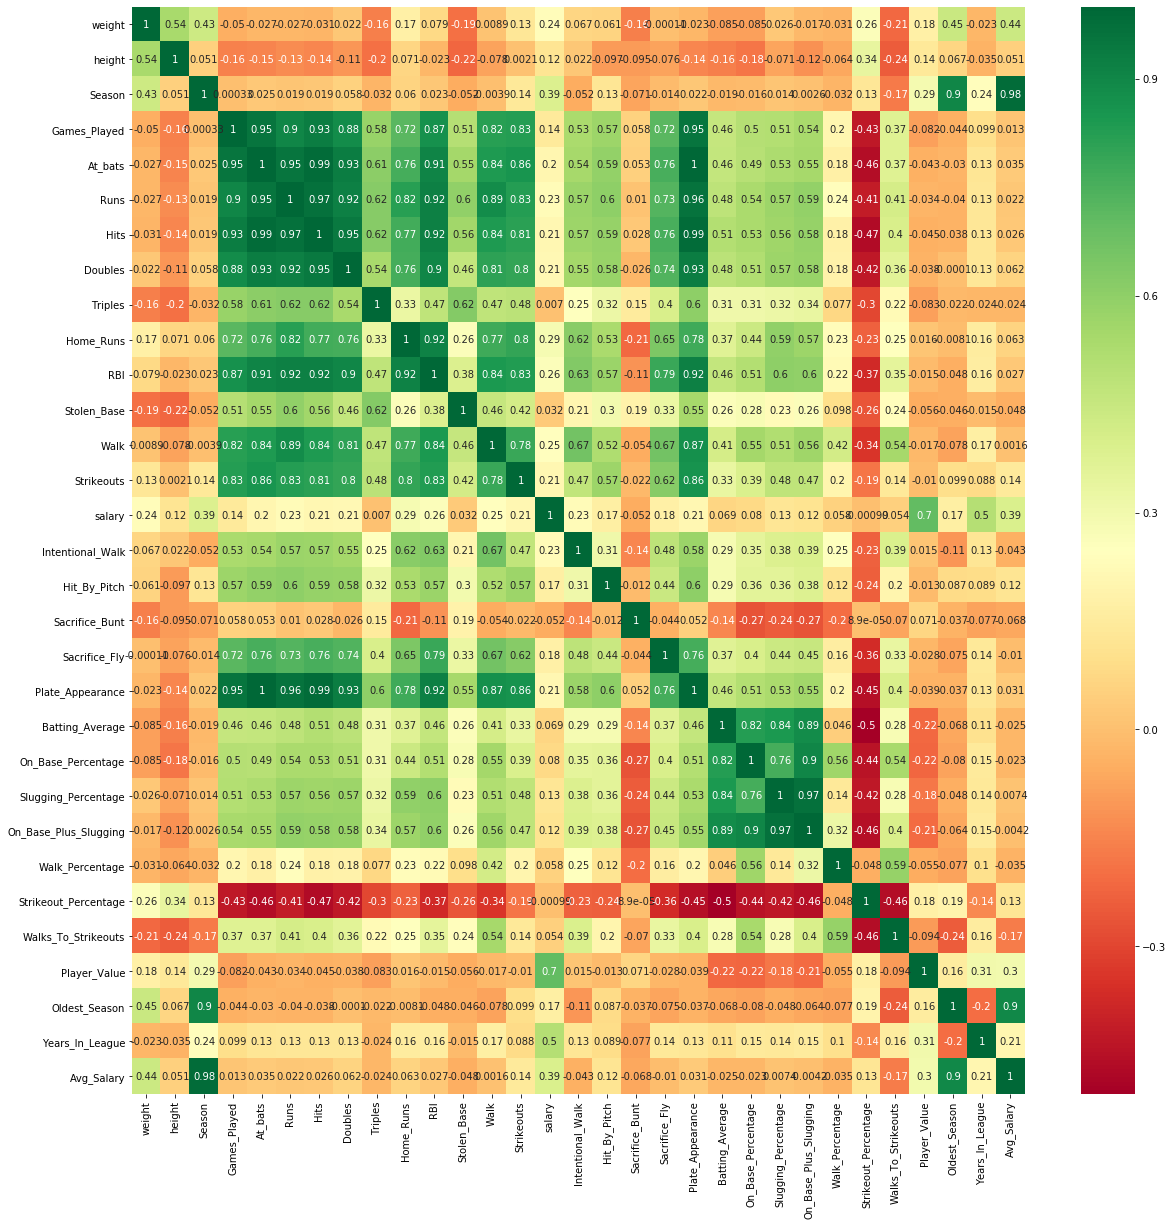

In [53]:
# get correlations of each features in dataset
corrmat = rest_of_league.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(rest_of_league[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [54]:
oak = df[df['teamID'] == 'OAK']

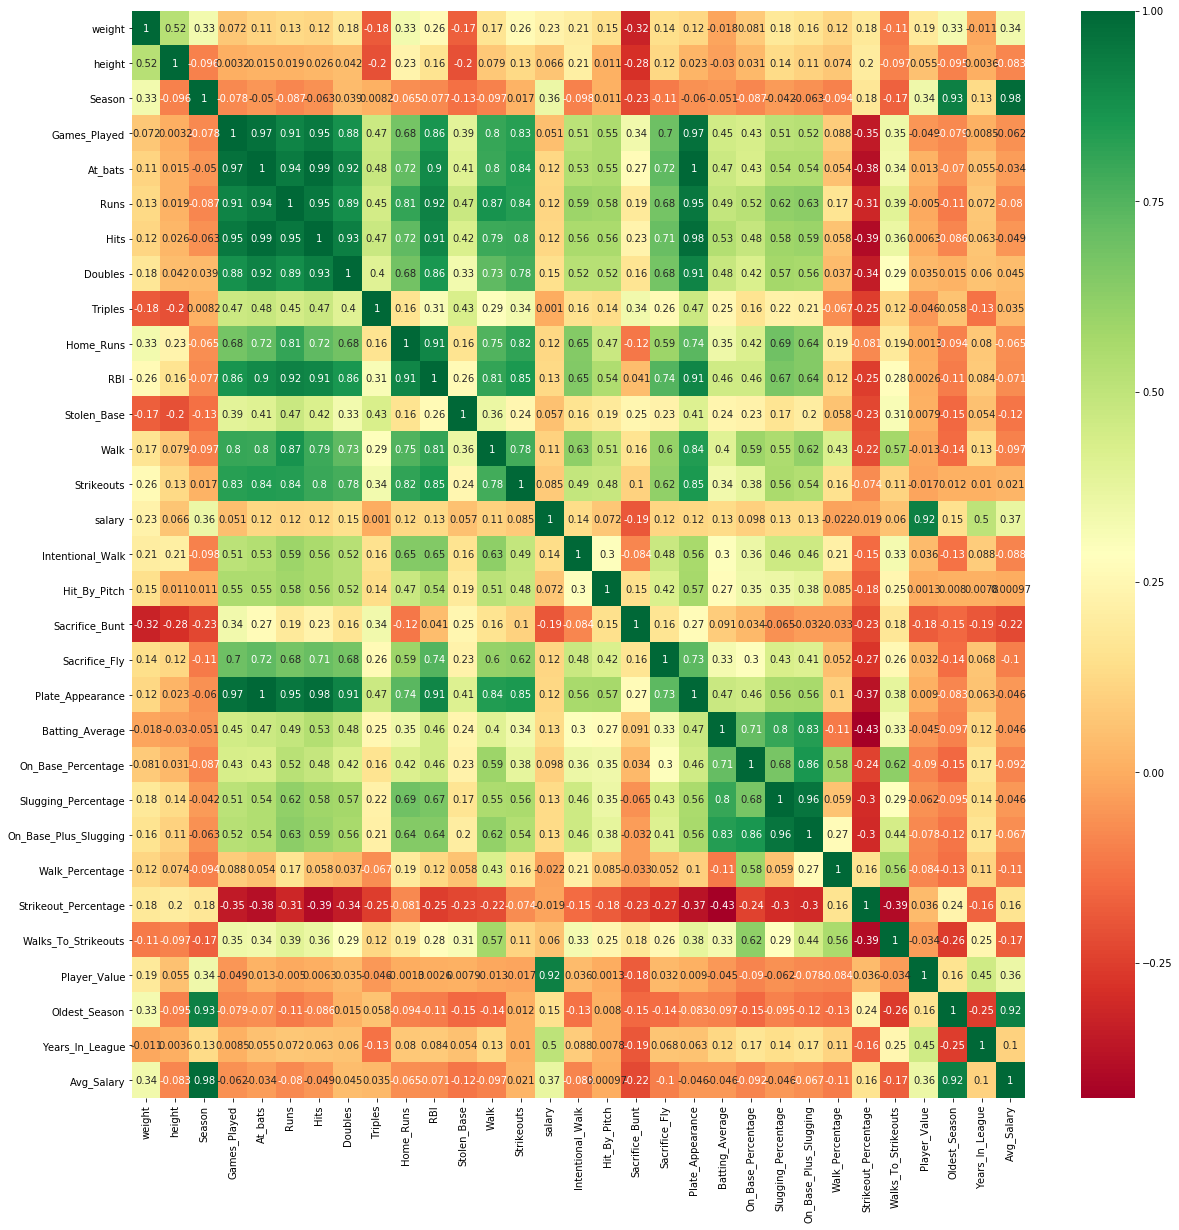

In [55]:
# get correlations of each features in dataset
corrmat = oak.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(oak[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [56]:
# mean absolute error
errors = df['Avg_Salary'] - df['salary']
mean_absolute_error = errors.abs().mean()
print(f"""If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of ${mean_absolute_error:,.0f}""")

If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of $2,255,393


In [57]:
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance',
       'Batting_Average', 'On_Base_Percentage', 'Slugging_Percentage',
       'On_Base_Plus_Slugging', 'Walk_Percentage', 'Strikeout_Percentage',
       'Walks_To_Strikeouts', 'Player_Value', 'Oldest_Season',
       'Years_In_League', 'Avg_Salary'],
      dtype='object')

In [58]:
# features
features = [
 'Season',
 'Games_Played',
 'At_bats',
 'Runs',
 'Hits',
 'Doubles',
 'Home_Runs',
 'RBI',
 'Walk',
 'Strikeouts',
 'Intentional_Walk',
 'Plate_Appearance',
 'On_Base_Percentage',
 'Batting_Average',
 'Slugging_Percentage',
 'On_Base_Plus_Slugging',
 'Walk_Percentage',
 'Strikeout_Percentage',
 'Walks_To_Strikeouts',
 'Years_In_League']

# shuffle data
df = shuffle(df)
# drop target
y = df.pop('salary')
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11339, 20), (3780, 20), (3780, 20), (11339,), (3780,), (3780,))

In [59]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs          Score
11  Plate_Appearance  914114.602510
2            At_bats  782933.645511
4               Hits  256461.946743
7                RBI  173604.264734
3               Runs  157718.716658
9         Strikeouts  148293.634800
8               Walk  141399.229470
1       Games_Played  126261.954130
6          Home_Runs   70831.323233
5            Doubles   56957.862658


/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



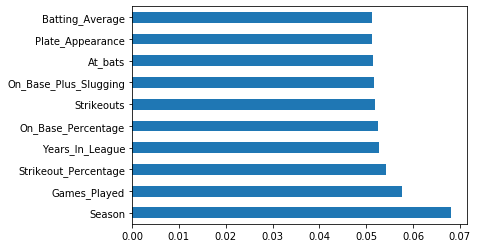

In [60]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

In [61]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 1797473.2714285713
R^2 0.1928949922921237


In [62]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    KNeighborsRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 1494798.4013227513
R^2: 0.4882182460017265


In [63]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Mean Absolute Error: 1361508.4869135802
R^2: 0.5623912539495062


In [64]:
Season = 1985
Games_Played = 120
At_bats = 170
Runs = 25
Hits = 100
Doubles = 8
Home_Runs = 40
RBI = 70
Walk = 30
Strikeouts = 30
Intentional_Walk = 2
Plate_Appearance = 180
On_Base_Percentage = .400
Batting_Average = .350
Slugging_Percentage = .500
On_Base_Plus_Slugging = .900
Walk_Percentage = .10
Strikeout_Percentage = .30
Walks_To_Strikeouts = .20
Years_In_League = 1

X_test = [[
 Season,
 Games_Played,
 At_bats,
 Runs,
 Hits,
 Doubles,
 Home_Runs,
 RBI,
 Walk,
 Strikeouts,
 Intentional_Walk,
 Plate_Appearance,
 On_Base_Percentage,
 Batting_Average,
 Slugging_Percentage,
 On_Base_Plus_Slugging,
 Walk_Percentage,
 Strikeout_Percentage,
 Walks_To_Strikeouts,
 Years_In_League]]

y_pred = pipeline.predict(X_test)
print(f'Predicted salary of ${y_pred.astype(int)[0]:,.0f}')

Predicted salary of $808,761


In [65]:
win_percentage = pd.read_csv('win-percentage.csv')
win_percentage.head()

Year    G   ARI  ATL  BAL  BLA  BOS  CHC  CHW  CIN  ...  PHI  PIT   SDP  \
0  2020   21   9.0   11   11  NaN    6   13   10    9  ...    6    4  11.0   
1  2019  162  85.0   97   54  NaN   84   84   72   75  ...   81   69  70.0   
2  2018  163  82.0   90   47  NaN  108   95   62   67  ...   80   82  66.0   
3  2017  162  93.0   72   75  NaN   93   92   67   68  ...   66   75  71.0   
4  2016  162  69.0   68   89  NaN   93  103   78   68  ...   71   78  68.0   

   SFG   SEA  STL   TBR   TEX   TOR   WSN  
0    8   7.0    2  12.0   9.0   7.0   7.0  
1   77  68.0   91  96.0  78.0  67.0  93.0  
2   73  89.0   88  90.0  67.0  73.0  82.0  
3   64  78.0   83  80.0  78.0  76.0  97.0  
4   87  86.0   86  68.0  95.0  89.0  95.0  

[5 rows x 33 columns]

In [66]:
win_percent = win_percentage.iloc[:, 2:].div(win_percentage.G, axis=0)
win_percent = win_percent.set_index(win_percentage['Year'])
win_percent = win_percent[4:36]
win_percent = win_percent.sort_index(ascending=True)
win_percent = win_percent.apply(lambda row: row.fillna(row.mean()), axis=1)
win_percent.head()

ARI       ATL       BAL       BLA       BOS       CHC       CHW  \
Year                                                                         
1985  0.498813  0.407407  0.512346  0.498813  0.500000  0.475309  0.524691   
1986  0.499050  0.444444  0.450617  0.499050  0.586420  0.432099  0.444444   
1987  0.499763  0.425926  0.413580  0.499763  0.481481  0.469136  0.475309   
1988  0.498101  0.333333  0.333333  0.498101  0.549383  0.475309  0.438272   
1989  0.499288  0.388889  0.537037  0.499288  0.512346  0.574074  0.425926   

           CIN       CLE       COL  ...       PHI       PIT       SDP  \
Year                                ...                                 
1985  0.549383  0.370370  0.498813  ...  0.462963  0.351852  0.512346   
1986  0.530864  0.518519  0.499050  ...  0.530864  0.395062  0.456790   
1987  0.518519  0.376543  0.499763  ...  0.493827  0.493827  0.401235   
1988  0.537037  0.481481  0.498101  ...  0.401235  0.524691  0.512346   
1989  0.462963  0.450617  0.499288  ...  0.413580  0.456790  0.549383   

           SFG       SEA       STL       TBR       TEX       TOR       WSN  
Year                                                                        
1985  0.382716  0.456790  0.623457  0.498813  0.382716  0.611111  0.518519  
1986  0.512346  0.413580  0.487654  0.499050  0.537037  0.530864  0.481481  
1987  0.555556  0.481481  0.586420  0.499763  0.462963  0.592593  0.561728  
1988  0.512346  0.419753  0.469136  0.498101  0.432099  0.537037  0.500000  
1989  0.567901  0.450617  0.530864  0.499288  0.512346  0.549383  0.500000  

[5 rows x 31 columns]

In [67]:
oak_win_percent = win_percent['OAK']
oak_win_percent = pd.DataFrame(oak_win_percent)
oak_win_percent.columns = ['Oak_Win_Percent']
oak_win_percent['League_Win_Percent'] = .500
oak_win_percent.head()

Oak_Win_Percent  League_Win_Percent
Year                                     
1985         0.475309                 0.5
1986         0.469136                 0.5
1987         0.500000                 0.5
1988         0.641975                 0.5
1989         0.611111                 0.5

In [68]:
# TODO get average for league and graph Oak vs average 
# average for league has to be .5

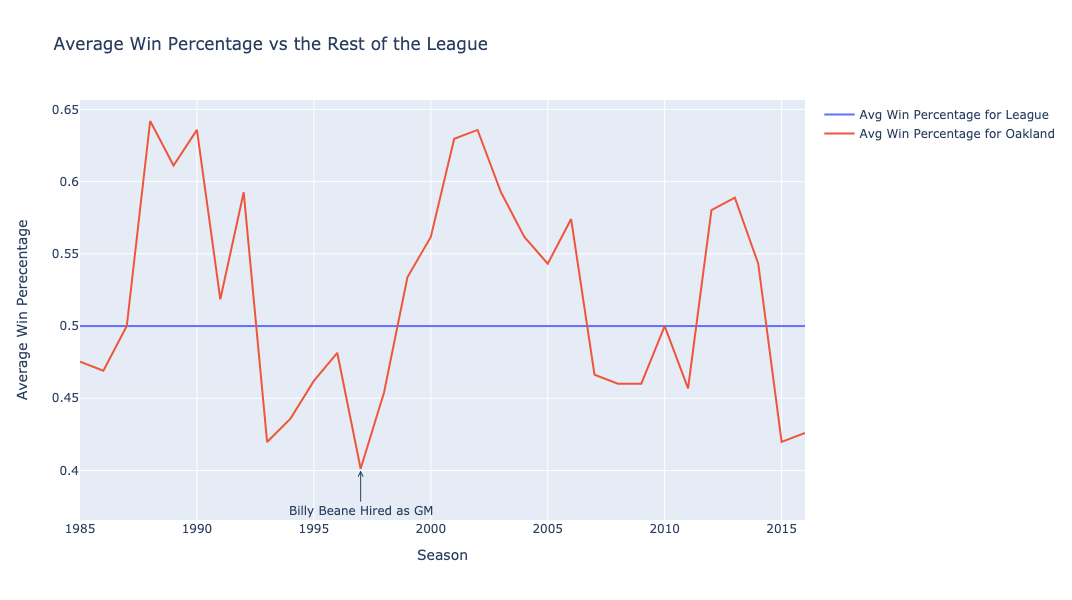

In [69]:
avg_league_wp = go.Scatter(x=oak_win_percent.index, y=oak_win_percent['League_Win_Percent'],
                      name='Avg Win Percentage for League')

avg_oakland_wp = go.Scatter(x=oak_win_percent.index, y=oak_win_percent['Oak_Win_Percent'],
                      name='Avg Win Percentage for Oakland')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Win Percentage vs the Rest of the League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Win Perecentage'))
                                                            
fig = go.Figure(data=[avg_league_wp, avg_oakland_wp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.4,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

# iplot(fig, filename = 'Average Win Percentage vs Rest of League', auto_open=True)

In [70]:
# wins per average salary?

In [71]:
# want to get dataframe with season as the index teams as columns and values as average salary for the team in that season

In [72]:
# load in dataset
df = pd.read_csv('MLB-Stats.csv')
print(df.shape)
df.head()

(28293, 28)


playerID    Player Name  weight  height bats throws  Season League teamID  \
0  aardsda01  David Aardsma     215      75    R      R    2004     NL    SFN   
1  aardsda01  David Aardsma     215      75    R      R    2007     AL    CHA   
2  aardsda01  David Aardsma     215      75    R      R    2008     AL    BOS   
3  aardsda01  David Aardsma     215      75    R      R    2009     AL    SEA   
4  aardsda01  David Aardsma     215      75    R      R    2012     AL    NYA   

                   Team  ... RBI  SB  BB  SO  salary  IBB  HBP  SH  SF  PA  
0  San Francisco Giants  ...   0   0   0   0  300000    0    0   0   0   0  
1     Chicago White Sox  ...   0   0   0   0  387500    0    0   0   0   0  
2        Boston Red Sox  ...   0   0   0   1  403250    0    0   0   0   1  
3      Seattle Mariners  ...   0   0   0   0  419000    0    0   0   0   0  
4      New York Yankees  ...   0   0   0   0  500000    0    0   0   0   0  

[5 rows x 28 columns]

In [73]:
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'salary', 'IBB', 'HBP', 'SH',
       'SF', 'PA'],
      dtype='object')

In [74]:
avg_team_salary = pd.pivot_table(df, values='salary', index='Season', columns='teamID')
avg_team_salary = avg_team_salary.apply(lambda row: row.fillna(row.mean()), axis=1)
avg_team_salary = avg_team_salary.astype(int)
avg_team_salary.head()

teamID     ANA     ARI     ATL     BAL     BOS     CAL     CHA     CHN  \
Season                                                                   
1985    476965  476965  668190  524922  448426  507354  459371  575126   
1986    418221  418221  595759  456157  517829  484388  450671  580605   
1987    427172  427172  457885  473384  643399  500936  450732  504555   
1988    459591  459591  435129  487312  577637  435353  249277  495596   
1989    503753  503753  321672  347482  638383  580685  338127  428407   

teamID     CIN     CLE  ...     PHI     PIT     SDN     SEA     SFN     SLN  \
Season                  ...                                                   
1985    376439  342583  ...  540566  564905  487460  255323  409605  459471   
1986    396599  256983  ...  354702  377950  471507  207478  320233  336250   
1987    366775  296043  ...  449105  260741  376297  275500  372031  388218   
1988    369641  376369  ...  532230  272290  359944  274868  485769  591745   
1989    375406  332396  ...  394161  421145  513333  361634  553904  640614   

teamID     TBA     TEX     TOR     WAS  
Season                                  
1985    476965  401323  453578  476965  
1986    418221  242124  461767  418221  
1987    427172  232000  446038  427172  
1988    459591  254187  486989  459591  
1989    503753  402423  597738  503753  

[5 rows x 35 columns]

In [75]:
win_total = win_percentage.set_index('Year')
win_total = win_total.drop('G', axis=1)
win_total = win_total.apply(lambda row: row.fillna(row.mean()), axis=1)
win_total = win_total[4:36]
win_total = win_total.sort_index(ascending=True)
win_total = win_total.astype(int)
win_total

ARI  ATL  BAL  BLA  BOS  CHC  CHW  CIN  CLE  COL  ...  PHI  PIT  SDP  \
Year                                                    ...                  
1985   80   66   83   80   81   77   85   89   60   80  ...   75   57   83   
1986   80   72   73   80   95   70   72   86   84   80  ...   86   64   74   
1987   80   69   67   80   78   76   77   84   61   80  ...   80   80   65   
1988   80   54   54   80   89   77   71   87   78   80  ...   65   85   83   
1989   80   63   87   80   83   93   69   75   73   80  ...   67   74   89   
1990   80   65   76   80   88   77   94   91   77   80  ...   77   95   75   
1991   80   94   67   80   84   77   87   74   57   80  ...   78   98   84   
1992   81   98   89   81   73   78   86   90   76   81  ...   70   96   82   
1993   81  104   85   81   80   84   94   73   76   67  ...   97   75   61   
1994   57   68   63   57   54   49   67   66   66   53  ...   54   53   47   
1995   72   90   71   72   86   73   68   85  100   77  ...   69   58   70   
1996   80   96   88   80   85   76   85   81   99   83  ...   67   73   91   
1997   80  101   98   80   78   68   80   76   86   83  ...   68   79   76   
1998   65  106   79   81   92   90   80   77   89   77  ...   75   69   98   
1999  100  103   78   80   94   67   75   96   97   72  ...   77   78   74   
2000   85   95   74   80   85   65   95   85   90   82  ...   65   69   76   
2001   92   88   63   80   82   88   83   66   91   73  ...   86   62   79   
2002   98  101   67   80   93   67   81   78   74   73  ...   80   72   66   
2003   84  101   71   80   95   88   86   69   68   74  ...   86   75   64   
2004   51   96   78   80   98   89   83   76   80   68  ...   86   72   87   
2005   77   90   74   81   95   79   99   73   93   67  ...   88   67   82   
2006   76   79   70   80   86   66   90   80   78   76  ...   85   67   88   
2007   90   84   69   81   96   85   72   72   96   90  ...   89   68   89   
2008   82   72   68   80   95   97   89   74   81   74  ...   92   67   63   
2009   70   86   64   81   95   83   79   78   65   92  ...   93   62   75   
2010   65   91   66   81   89   75   88   91   69   83  ...   97   57   90   
2011   94   89   69   80   90   71   79   79   80   73  ...  102   72   71   
2012   81   94   93   81   69   61   85   97   68   64  ...   81   79   76   
2013   81   96   85   81   97   66   63   90   92   74  ...   73   94   76   
2014   64   79   96   81   71   73   73   76   85   66  ...   73   88   77   
2015   79   67   81   80   78   97   76   64   81   68  ...   63   98   74   
2016   69   68   89   80   93  103   78   68   94   75  ...   71   78   68   

      SFG  SEA  STL  TBR  TEX  TOR  WSN  
Year                                     
1985   62   74  101   80   62   99   84  
1986   83   67   79   80   87   86   78  
1987   90   78   95   80   75   96   91  
1988   83   68   76   80   70   87   81  
1989   92   73   86   80   83   89   81  
1990   85   77   70   80   83   86   85  
1991   75   83   84   80   85   91   71  
1992   72   64   83   81   77   96   87  
1993  103   82   87   81   86   95   94  
1994   55   49   53   57   52   55   74  
1995   67   79   62   72   74   56   66  
1996   68   85   88   80   90   74   88  
1997   90   90   73   80   77   76   78  
1998   89   76   83   63   88   88   65  
1999   86   79   75   69   95   84   68  
2000   97   91   95   69   71   83   67  
2001   90  116   93   62   73   80   68  
2002   95   93   97   55   72   78   83  
2003  100   93   85   63   71   86   83  
2004   91   63  105   70   89   67   67  
2005   75   69  100   67   79   80   81  
2006   76   78   83   61   80   87   71  
2007   71   88   78   66   75   83   73  
2008   72   61   86   97   79   86   59  
2009   88   85   91   84   87   75   59  
2010   92   61   86   96   90   85   69  
2011   86   67   90   91   96   81   80  
2012   94   75   88   90   93   73   98  
2013   76   71   97   92   91   74   86  
2014   88   87   90   77   67   83   96  
2015   84

In [76]:
avg_team_salary.columns

Index(['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE',
       'COL', 'DET', 'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIA', 'MIL', 'MIN',
       'ML4', 'MON', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN',
       'SLN', 'TBA', 'TEX', 'TOR', 'WAS'],
      dtype='object', name='teamID')

In [77]:
win_percent.columns

Index(['ARI', 'ATL', 'BAL', 'BLA', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL',
       'DET', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY',
       'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'SEA', 'STL', 'TBR', 'TEX', 'TOR',
       'WSN'],
      dtype='object')

In [78]:
salary_per_win = avg_team_salary / win_total
salary_per_win = salary_per_win.dropna(axis=1)
salary_per_win['mean'] = salary_per_win.mean(axis=1)
league_salary_per_win = salary_per_win.loc[:, salary_per_win.columns != 'OAK']
league_salary_per_win

ARI           ATL           BAL           BOS           CIN  \
Season                                                                         
1985     5962.062500  10124.090909   6324.361446   5536.123457   4229.651685   
1986     5227.762500   8274.430556   6248.726027   5450.831579   4611.616279   
1987     5339.650000   6636.014493   7065.432836   8248.705128   4366.369048   
1988     5744.887500   8057.944444   9024.296296   6490.303371   4248.747126   
1989     6296.912500   5105.904762   3994.045977   7691.361446   5005.413333   
1990     6624.787500   6458.507692   3540.171053   7931.272727   5336.934066   
1991    11107.300000   7270.872340   7345.850746  13717.261905  13119.945946   
1992    13323.395062  12351.295918   8548.022472  19486.547945  14288.877778   
1993    12376.123457  13352.971154  10569.717647  15657.075000  17634.506849   
1994    18562.298246  23786.926471  20220.412698  21846.074074  20194.287879   
1995    13569.902778  17060.755556  16474.225352  11044.616279  14807.541176   
1996    12544.875000  15511.677083  17600.875000  12610.141176  12740.839506   
1997    15434.525000  16453.742574  20981.367347  15320.423077  14278.881579   
1998    15110.446154  16709.509434  28823.177215  17831.521739   8470.233766   
1999    19313.420000  21026.349515  27584.179487  22180.106383  13105.093750   
2000    33996.011765  29371.578947  33107.770270  32463.129412  19805.541176   
2001    30312.217391  36005.556818  31730.412698  41401.829268  29971.772727   
2002    30712.826531  36023.900990  23084.044776  41616.860215  21909.820513   
2003    40248.511905  36958.504950  27866.943662  35324.505263  30889.884058   
2004    45550.745098  32896.010417  20798.217949  42022.051020  22669.289474   
2005    29137.298701  35910.633333  37970.959459  40043.652632  28251.397260   
2006    32993.052632  36956.493671  39658.157143  51812.569767  25953.050000   
2007    22177.622222  35107.464286  44990.710145  49696.593750  30704.513889   
2008    31937.439024  46994.652778  29985.088235  50395.589474  32754.283784   
2009    38851.100000  41733.000000  39081.343750  45115.778947  42425.294872   
2010    36599.046154  39293.461538  46025.530303  59141.314607  30091.098901   
2011    24564.436170  38174.224719  44462.362319  58689.744444  32045.202532   
2012    32499.925926  29295.595745  31477.344086  61004.014493  30700.206186   
2013    36432.493827  32070.572917  39564.435294  54729.690722  45771.133333   
2014    56923.312500  48276.594937  37057.614583  70543.000000  50854.078947   
2015    26313.392405  63397.447761  50610.012346  65505.500000  65435.343750   
2016    48739.710145  48180.029412  61109.438202  67978.247312  46445.397059   

                 CLE           COL           DET           HOU           LAA  \
Season                                                                         
1985     5709.716667   5962.062500   6183.750000   6065.084337   5299.611111   
1986     3059.321429   5227.762500   5257.241379   4348.312500   4545.880435   
1987     4853.163934   5339.650000   5296.816327   5905.013158   5695.626667   
1988     4825.243590   5744.887500   6691.238636   6051.426829   6127.880000   
1989     4553.369863   6296.912500   8968.576271   6720.093023   5535.747253   
1990     5871.649351   6624.787500   6965.177215   8168.333333   6624.787500   
1991     9372.666667  11107.300000  11351.583333   7909.230769  10970.172840   
1992     3319.934211  13323.395062  13879.586667   6471.901235  14988.819444   
1993     6250.763158   6441.537313  14031.811765  12255.776471  14119.239437   
1994    13813.984848  13590.226415  24850.528302  15785.575758  22511.723404   
1995    11570.760000  13813.285714  17301.466667  13043.802632  12526.064103   
1996    16842.030303  13513.481928  14590.415094  10742.243902  14337.000000   
1997    19609.372093  16859.771084   7315.101266  13159.404762  14699.547619   
1998    18162.157303  23242.259740  10394.230769  14436.274510  15447.552941   
1999    18603.78

In [79]:
oak_salary_per_win = salary_per_win.loc[:, salary_per_win.columns == 'OAK']
oak_salary_per_win.astype(int)

OAK
Season       
1985     5890
1986     4286
1987     5825
1988     4051
1989     6509
1990     6435
1991    17219
1992    15806
1993    14996
1994    22403
1995    17307
1996     7458
1997     8992
1998     9974
1999    11264
2000    13573
2001    12579
2002    15636
2003    21126
2004    24294
2005    24421
2006    25564
2007    32800
2008    27075
2009    29270
2010    24007
2011    31208
2012    21851
2013    22309
2014    38166
2015    41329
2016    44465

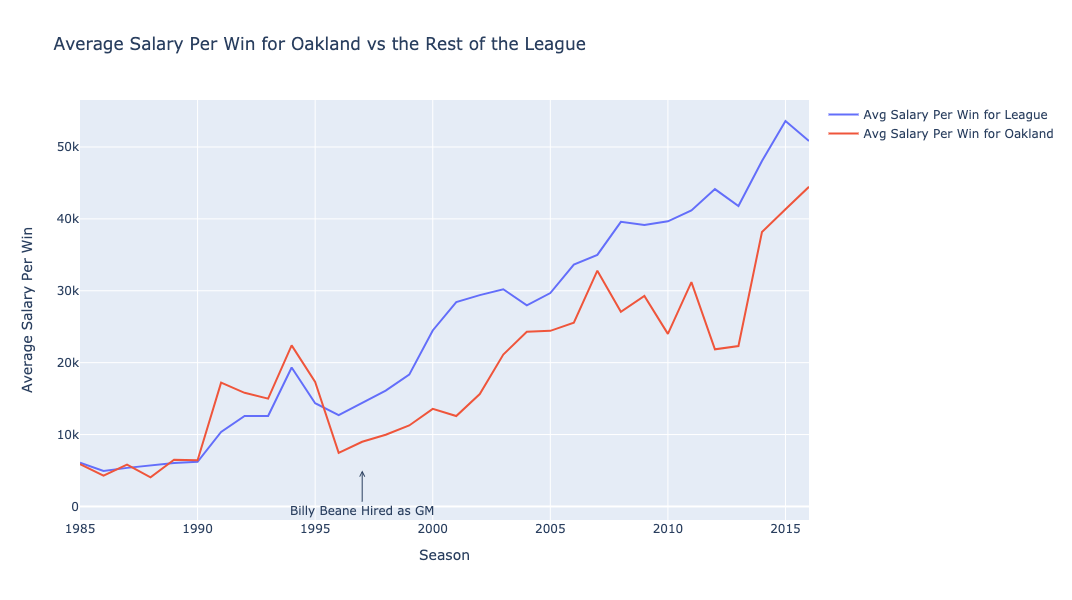

In [80]:
avg_league_swp = go.Scatter(x=league_salary_per_win.index, y=league_salary_per_win['mean'],
                      name='Avg Salary Per Win for League')

avg_oakland_swp = go.Scatter(x=oak_salary_per_win.index, y=oak_salary_per_win['OAK'],
                      name='Avg Salary Per Win for Oakland')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Salary Per Win for Oakland vs the Rest of the League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Salary Per Win'))
                                                            
fig = go.Figure(data=[avg_league_swp, avg_oakland_swp], layout=layout)

fig.add_annotation(
            x=1997,
            y=5000,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

# iplot(fig, filename = 'Average Salary Per Win vs Rest of League', auto_open=True)

In [81]:
# TODO - add wins to rest of data to see correlations between stats and wins